# Neural Algorithm of Artistic Style Transfer

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Setup

Import libraries

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

# torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True

Setup directory and file paths

In [3]:
PATH = Path('data/imagenet')
PATH_TRN = PATH / 'train'

Initialize pre-trained VGG model

In [4]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

Grab and show an image from ImageNet

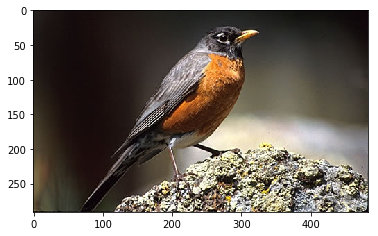

In [7]:
img_fn = PATH_TRN / 'n01558993' / 'n01558993_9684.JPEG'
img = open_image(img_fn)
plt.imshow(img)

## Content loss

Let's start by trying to create a bird that initially is random noise and we are going to use perceptual loss (content loss) to create something that is bird-like but it's not the particular bird.

In [8]:
sz = 288

So we are going to stick it through some transforms for VGG16 model.

In [9]:
trn_tfms, val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

Now we have something of 3 by 288 by 288 because PyTorch likes the channel to be first. As you can see, it's been turned into a square for us, it's been normalized to (0, 1), all that normal stuff.

We are going to start with this picture:

Now we are creating a random image.

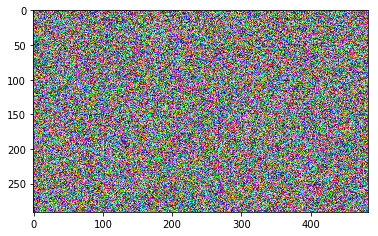

In [10]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img)

Trying to turn this into a picture of anything is actually really hard. I found it very difficult to actually get an optimizer to get reasonable gradients that went anywhere. And just as I thought I was going to run out of time for this class and really embarrass myself, I realized the key issue is that pictures don't look like this. They have more smoothness, so I turned this into the following by blurring it a little bit:

In [11]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8, 8, 1])

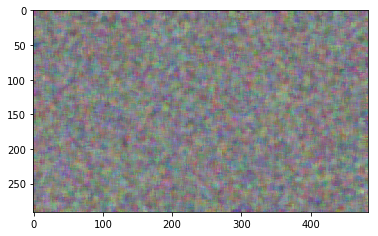

In [12]:
plt.imshow(opt_img)

As soon as we change it to this, it immediately started training really well. A number of little tweaks you have to do to get these things to work is kind of insane, but here is a little tweak.

So we start with a random image which is at least somewhat smooth. We found that my bird image had a mean of pixels that was about half of this, so we divided it by 2 just trying to make it a little bit easier for it to match (we don't know if it matters). Turn that into a variable because this image, remember, we are going to be modifying those pixels with an optimization algorithm, so anything that's involved in the loss function needs to be a variable. And specifically, it requires a gradient because we are actually updating the image.

In [13]:
opt_img = val_tfms(opt_img) / 2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

So we now have a mini batch of 1, 3 channels, 288 by 288 random noise.

We are going to use, for no particular reason, the 37th layer of VGG. If you print out the VGG network (you can just type in `m_vgg` and prints it out), you'll see that this is mid to late stage layer. So we can just grab the first 37 layers and turn it into a sequential model. So now we have a subset of VGG that will spit out some mid layer activations, and that's what the model is going to be.

In [14]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

So now we can take our actual bird image and we want to create a mini batch of one. Remember, if you slice in NumPy with `None`, also known as `np.newaxis`, it introduces a new unit axis in that point. Here, I want to create an axis of size 1 to say this is a mini batch of size one. So slicing with `None` just like we did here to get one unit axis at the front. Then we turn that into a variable and this one doesn't need to be updated, so we use `VV` to say you don't need gradients for this guy. So that is going to give us our target activations.

In [15]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

Limited memory Broyden–Fletcher–Goldfarb–Shanno (LBFGS)

In [16]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [17]:
def actn_loss(x):
    return F.mse_loss(m_vgg(x), targ_v) * 1000

In [18]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    # passing in that randomly generated image — the variable of optimization image to the loss function
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter += 1
    if n_iter % show_iter == 0:
        print(f'Iteration: n_iter, loss: {loss.data[0]}')
    return loss

As you can see here, when you say `optimizer.step`, you actually pass in the loss function. So our loss function is to call `step` with a particular loss function which is our activation loss (`actn_loss`).

We run that bunch of times and we'll print it out. And we have our bird but not the representation of it.

In [19]:
n_iter = 0
while n_iter <= max_iter:
    optimizer.step(partial(step, actn_loss))

Iteration: n_iter, loss: 0.8200027942657471
Iteration: n_iter, loss: 0.3576483130455017
Iteration: n_iter, loss: 0.23157010972499847
Iteration: n_iter, loss: 0.17518416047096252
Iteration: n_iter, loss: 0.14312393963336945
Iteration: n_iter, loss: 0.1230238527059555
Iteration: n_iter, loss: 0.10892671346664429
Iteration: n_iter, loss: 0.09870683401823044
Iteration: n_iter, loss: 0.09066757559776306
Iteration: n_iter, loss: 0.08464114367961884


So you can see the loss function going down. The mean squared error between the activations at layer 37 of our VGG model for our optimized image vs. the target activations, remember the target activations were the VGG applied to our bird.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


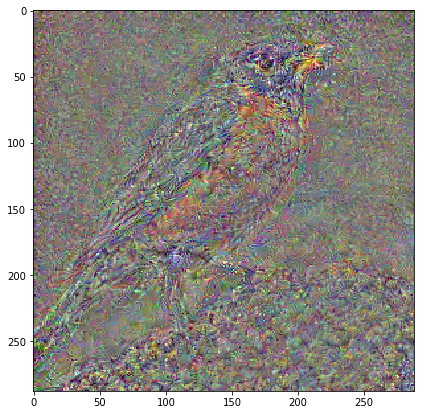

In [20]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data), 1, 4))[0]
plt.figure(figsize=(7, 7))
plt.imshow(x)

## Forward hook

PyTorch has these fantastic things called **hooks**. You can have forward hooks that let you plug anything you like into the forward pass of a calculation or a backward hook that lets you plug anything you like into the backward pass. So we are going to create the world's simplest forward hook.

`m` is going to be the layer that I'm going to hook. When its forward method is called, it will call `self.hook_fn` which will store the output in an attribute called `features`.

In [21]:
class SaveFeatures():
    features = None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [22]:
m_vgg = to_gpu(vgg16(True)).eval()
# set it to not trainable so we don't waste time and memory calculating gradients for it.
set_trainable(m_vgg, False)

Go through and find all the max pool layers. Go through all of the children of this module and if it's a max pool layer, let's spit out index minus 1 — so that's going to give us the layer before the max pool. In general, the layer before a max pool or stride 2 conv is a very layer. It's the most complete representation we have at that grid cell size because the very next layer is changing the grid. So that seems to us like a good place to grab the content loss from. The best most semantic, most interesting content we have at that grid size. So that's why we are going to pick those indexes.

In [23]:
# these are the indexes of the last layer before each max pool in VGG.
block_ends = [i - 1 for i, o in enumerate(children(m_vgg))
              if isinstance(o, nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [24]:
# will give usthe 32nd layer of VGG as a module.
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

Now, every time we do a forward pass on this VGG model, it's going to store the 32nd layer's output inside `sf.features`.

`get_opt` give us our random image to optimize and an optimizer to optimize that image.

In [25]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8, 8, 1])
    opt_img_v = V(val_tfms(opt_img / 2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [26]:
opt_img_v, optimizer = get_opt()

Call VGG network, throwing away the answer, and then grabbing the features we stored in our `SaveFeatures` object.

`m_vgg()` — this is how you do a forward path in PyTorch. You don't say `m_vgg.forward()`, you just use it as a callable. Using as a callable on an `nn.module` automatically calls `forward`. That's how PyTorch modules work.

So we call it as a callable, that ends up calling our forward hook, that forward hook stores the activations in `sf.features`, and so now we have our target variable — just like before but in a much more flexible way.

In [27]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

Do a forward pass, throws away the results, and and grabs `sf.features`. So that's now our 32nd layer activations which we can then do my MSE loss on.

You might have noticed, the last loss function and this one are both multiplied by a thousand. Why are they multiplied by a thousand? The loss functions — the numbers are really low (like 10E-7) and Jeremy thought what if they weren't so low. So he multiplied them by a thousand and it started working.

In [28]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v) * 1000

In [29]:
n_iter = 0
while n_iter <= max_iter:
    optimizer.step(partial(step, actn_loss2))

Iteration: n_iter, loss: 0.2201523780822754
Iteration: n_iter, loss: 0.09734754264354706
Iteration: n_iter, loss: 0.06434715539216995
Iteration: n_iter, loss: 0.04877760633826256
Iteration: n_iter, loss: 0.03993375599384308
Iteration: n_iter, loss: 0.03418143838644028
Iteration: n_iter, loss: 0.030093519017100334
Iteration: n_iter, loss: 0.026956692337989807
Iteration: n_iter, loss: 0.024544663727283478
Iteration: n_iter, loss: 0.022647056728601456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


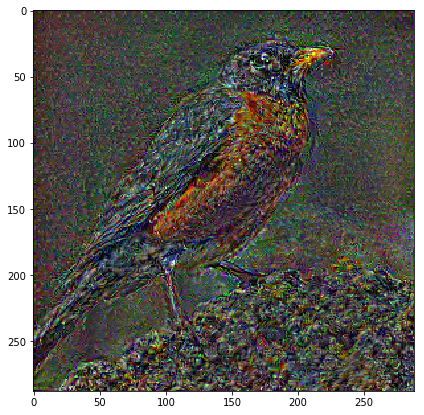

In [30]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data), 1, 4))[0]
plt.figure(figsize=(7, 7))
plt.imshow(x)

The bird looks more bird-like. Hopefully that makes sense to you that earlier layers are getting closer to the pixels. There are more grid cells, each cell is smaller, smaller receptive field, less complex semantic features. So the earlier we get, the more it's going to look like a bird.

In [31]:
sf.close()

## Style match

The next thing we need to do is to **create style loss**. We've already got the loss which is how much like the bird is it. Now we need how like this painting style is it. And we are going to do nearly the same thing. We are going to **grab the activations of some layer**. Now the problem is, the activations of some layer, let's say it was a 5x5 layer (of course there are no 5x5 layers, it's 224x224, but we'll pretend). So here're some activations and we could get these activations both per the image we are optimizing and for our Van Gogh painting. Let's look at our Van Gogh painting. There it is — The Starry Night.

In [32]:
style_fn = PATH / 'style' / 'starry_night.jpg'

In [34]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((900, 1136, 3), (291, 483, 3))

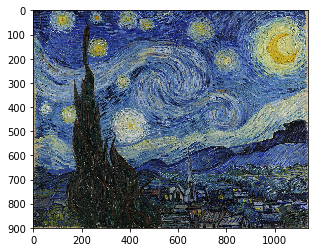

In [35]:
plt.imshow(style_img)

So we can do that for our Van Gogh image and we can do that for our optimized image. Then we can compare the two and we would end up creating an image that has content like the painting but it's not the painting — that's not what we want. We want something with the same style but it's not the painting and doesn't have the content. So we want to throw away all of the spatial information. We are not trying to create something that has a moon here, stars here, and a church here. We don't want any of that. So how do we throw away all the special information?

In [38]:
def scale_match(src, targ):
    h, w, _ = src.shape
    sh, sw, _ = targ.shape
    rat = max(h / sh, w / sw)
    print(rat)
    res = cv2.resize(targ, (int(sw * rat), int(sh * rat)))
    return res[:h, :w]

In [39]:
style = scale_match(img, style_img)

0.4251760563380282


So here is our painting. We've tried to resize the painting so it's the same size as our bird picture. So that's all this is just doing. It doesn't matter too much which bit we use as long as it's got lots of the nice style in it.

((291, 483, 3), (291, 483, 3))

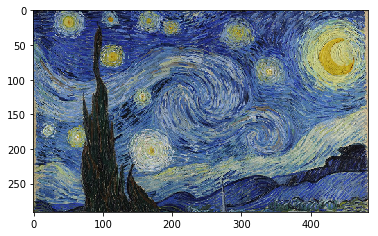

In [40]:
plt.imshow(style)
style.shape, img.shape

We grab our optimizer and our random image just like before:

In [54]:
opt_img_v, optimizer = get_opt()

Save features for all blocks.

In [55]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [56]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

`style_img` is our Van Gogh painting. So we take my `style_img`, put it through my transformations to create our transform style image (`style_tfm`).

In [57]:
style_tfm = val_tfms(style_img)

Turn that into a variable, put it through the forward pass of our VGG module, and now we can go through all of my `SaveFeatures` objects and grab each set of features. Notice we call `clone` because later on, if we call our VGG object again, it's going to replace those contents. So here is now an array of the activations at every `block_end` layer. And here, you can see all of those shapes:

In [58]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

### Gram matrix

To normalize it, we'll divide that by the number of elements (`b*c*h*w`) — it would actually be more elegant if I had said `input.numel` (number of elements) that would be the same thing. Again, this gave me tiny numbers so I multiply it by a big number to make it something more sensible.

In [59]:
def gram(input):
    b, c, h, w = input.size()
    x = input.view(b * c, -1)
    return torch.mm(x, x.t()) / input.numel() * 1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

### Style loss

So now our style loss is to take our image to optimize, throw it through VGG forward pass, grab an array of the features in all of the `SaveFeatures` objects, and then call our Gram MSE loss on every one of those layers. And that's going to give us an array and then we just add them up. Now you could add them up with different weightings, you could add up subsets, or whatever. In this case, we are just grabbing all of them.

In [60]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o, s in zip(outs, targ_styles)]
    return sum(losses)

In [61]:
n_iter = 0
while n_iter <= max_iter:
    optimizer.step(partial(step, style_loss))

Iteration: n_iter, loss: 488.1943664550781
Iteration: n_iter, loss: 160.02984619140625
Iteration: n_iter, loss: 85.17698669433594
Iteration: n_iter, loss: 51.89944076538086
Iteration: n_iter, loss: 34.03820037841797
Iteration: n_iter, loss: 23.21661949157715
Iteration: n_iter, loss: 16.497699737548828
Iteration: n_iter, loss: 12.354783058166504
Iteration: n_iter, loss: 9.861383438110352
Iteration: n_iter, loss: 8.337841987609863


And here we have a random image in the style of Van Gogh.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


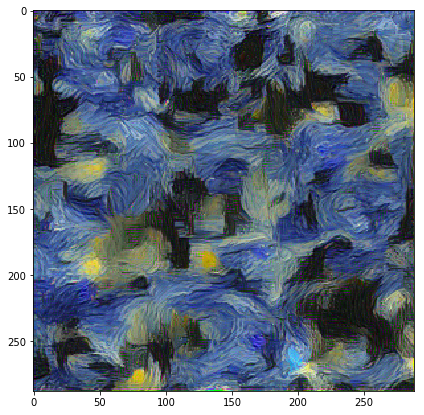

In [62]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data), 1, 4))[0]
plt.figure(figsize=(7, 7))
plt.imshow(x)

We added this `SaveFeatures.close` which just calls `self.hook.remove()`. Remember, we stored the hook as `self.hook` so `hook.remove()` gets rid of it. It's a good idea to get rid of it because otherwise you can potentially just keep using memory. So at the end, we just go through each of our `SaveFeatures` object and close it:

In [ ]:
# Don't close the forward hook at this point, else we will encounter a problem later (line 53)

# for sf in sfs:
#     sf.close()

In [63]:
opt_img_v, optimizer = get_opt()

### Style transfer

Style transfer is adding content loss and style loss together with some weight.

Our combined loss is the MSE loss at one particular layer, our style loss at all of our layers, sum up the style losses, add them to the content loss, the content loss we are scaling. Actually the style loss, we scaled already by 1E6. So they are both scaled exactly the same. Add them together. Again, you could trying weighting the different style losses or you could maybe remove some of them, so this is the simplest possible version.

In [64]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    # gram matrix loss
    losses = [gram_mse_loss(o, s) for o, s in zip(outs, targ_styles)]
    # content loss
    cnt_loss = F.mse_loss(outs[3], targ_vs[3]) * 1e6
    # style loss
    style_loss = sum(losses)
    return cnt_loss + style_loss

Train that.

In [53]:
# this run is errornous due to closing the forward hook earlie.
n_iter = 0
while n_iter <= max_iter:
    optimizer.step(partial(step, comb_loss))

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [65]:
# re-run after fixing the previous problem by not closing the forward hook
# after the style transfer, cell 50.
# Solution is in the fast.ai forum: http://forums.fast.ai/t/part-2-lesson-13-wiki/15297/171?u=cedric

n_iter = 0
while n_iter <= max_iter:
    optimizer.step(partial(step, comb_loss))

Iteration: n_iter, loss: 1683.57763671875
Iteration: n_iter, loss: 1178.25
Iteration: n_iter, loss: 999.766357421875
Iteration: n_iter, loss: 893.4268798828125
Iteration: n_iter, loss: 827.3020629882812
Iteration: n_iter, loss: 782.7379150390625
Iteration: n_iter, loss: 750.3278198242188
Iteration: n_iter, loss: 727.0342407226562
Iteration: n_iter, loss: 708.3321533203125
Iteration: n_iter, loss: 693.3798828125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 287.5, 287.5, -0.5)

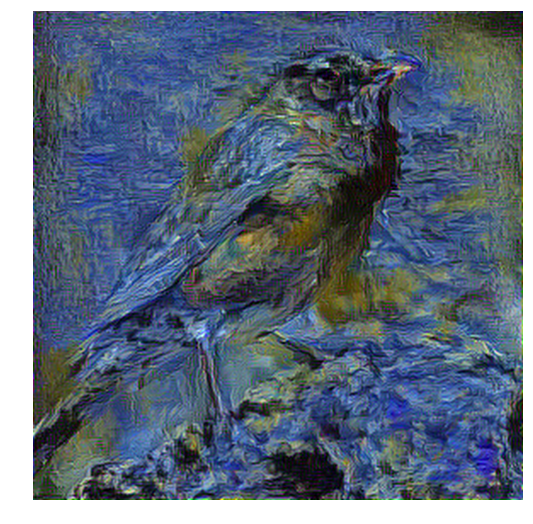

In [66]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data), 1, 4))[0]
plt.figure(figsize=(9, 9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off')

In [67]:
for sf in sfs:
    sf.close()